# 序列模型

In [1]:
import torch
from torch import nn
import d2l.torch as d2l
import matplotlib.pyplot as plt

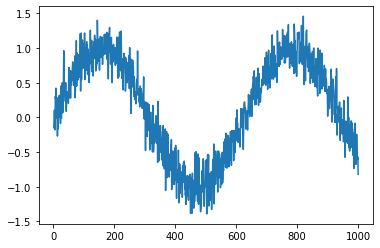

In [2]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # tuple 加上逗号避免歧义
plt.plot(time, x);

$\tau$ 的取值如果过大的话会导致 train example 变少, 但是看得也更多, 所以需要权衡 $\tau$ 的大小

In [3]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau): # 如果不丢弃的话就使用0去填充序列
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))
batch_size, n_train = 16, 600
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features[:n_train], labels[:n_train]), batch_size, shuffle=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch{epoch + 1} , loss{d2l.evaluate_loss(net, train_iter, loss):f}')

训练模型

In [6]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch1 , loss0.076351
epoch2 , loss0.060589
epoch3 , loss0.058509
epoch4 , loss0.054933
epoch5 , loss0.056429


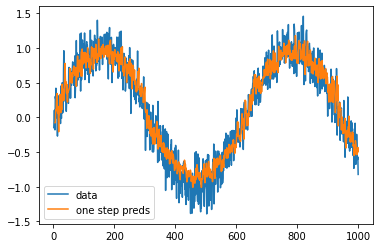

In [7]:
onestep_preds = net(features)
fig, ax = plt.subplots()
ax.plot(time, x.detach().numpy())
ax.plot(time[tau:], onestep_preds.detach().numpy())
ax.legend(['data', 'one step preds']);

预测久了, 积累的误差多了, 预测就会不准

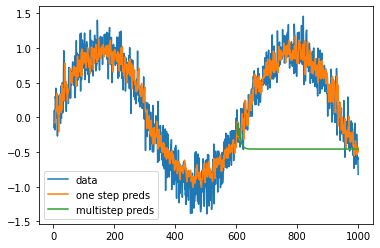

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))
fig, ax = plt.subplots()
ax.plot(time, x.detach().numpy())
ax.plot(time[tau:], onestep_preds.detach().numpy())
ax.plot(time[n_train+tau:], multistep_preds[n_train + tau:].detach().numpy())
ax.legend(['data', 'one step preds', 'multistep preds']);

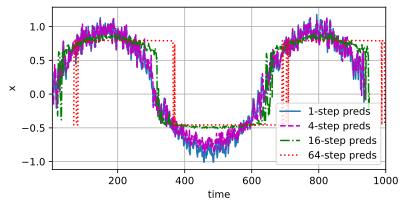

In [9]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))
for i in range(tau):
    features[:, i] = x[i:i+T-tau-max_steps+1]
for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))